In [1]:
import os
import sys
import gc; gc.enable()
import warnings; warnings.filterwarnings("ignore")

import pickle
from tqdm import tqdm
# import multiprocessing

import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
#from torch.utils.data import Dataset, DataLoader

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool
from torch_geometric.loader import DataLoader

from openbabel import pybel
pybel.ob.obErrorLog.SetOutputLevel(0)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
data = pd.read_csv('../Clean/train.csv', index_col=0)
test = pd.read_csv('../Clean/test.csv', index_col=0)

## build graphs

In [3]:
#from graph_creation_baseline import build_graphs

#extra_features_table = pd.read_csv('../atom_features.csv', index_col=0)

#data_graphs = build_graphs(np.concatenate([data['Smiles'].values, test['Smiles'].values]),
#                           extra_features_table=extra_features_table)
#test_graphs = data_graphs[-len(test):]
#data_graphs = data_graphs[:-len(test)]
#for index in range(len(data_graphs)):
#    data_graphs[index].y = int(data['Active'].values[index])

In [3]:
from pybel_molecule import build_molecules_pybel

data_molecules = build_molecules_pybel(data['Smiles'].values)
data_targets = data['Active'].values.astype(np.int64)
for index in range(len(data_molecules)):
    data_molecules[index].y = int(data['Active'].values[index])

test_molecules = build_molecules_pybel(test['Smiles'].values, fixed=True)

100%|████████████████████████████████████████████████████████████████████| 1614/1614 [02:55<00:00,  9.22it/s]


## engine

In [4]:
from utils import *

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MoleculeDataset(Dataset):
    def __init__(self, molecules, targets=None, augment=False):
        self.molecules, self.targets = molecules, targets
        self.augment = augment
    
    
    def __len__(self):
        return len(self.molecules)
    
    
    def __getitem__(self, index):
        if self.augment:
            self.molecules[index].augment()
        tensor = self.molecules[index].build_tensor()
        if self.targets is None:
            return {'tensor': tensor}
        target = self.targets[index]
        return {'tensor': tensor, 'target': target}

## model

In [5]:
import torch
import torch.nn as nn
from timm.models.resnet import resnet18

#def build_model(num_channels):

class ModelResnet18(nn.Module):
    def __init__(self, num_features):
        super(self.__class__, self).__init__()
        self.model = resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(num_features, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        self.model.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        
    def forward(self, x):
        return self.model.forward(x)[:, 0]

## args

In [9]:
# data split args
n_splits, random_state = 8, 42

# positive objects rebalance args
num_pos_repeats, pos_weight = 4, 6.0

# model args
num_features, width, depth = 46, 256, 2
device = torch.device('cuda:0')

# fit args
batch_size, num_workers = 32, 8
lr, num_epochs = 1e-3, 64

# name for logs and checkpoints
name = 'cv_'

## train

In [10]:
from torch.utils.data import DataLoader

#thrs, f1s = [], []
for index in range(n_splits):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    tmp = cv.split(data['Smiles'].values, data['Active'].values.astype(np.int64))

    for _ in range(index + 1):
        train_indices, val_indices = tmp.__next__()

    train_molecules = [data_molecules[index] for index in train_indices]
    val_molecules = [data_molecules[index] for index in val_indices]
    
    train_targets = [data_targets[index] for index in train_indices]
    val_targets = [data_targets[index] for index in val_indices]

    #positive_train_graphs = [graph for graph in train_graphs if graph.y]
    #if num_pos_repeats > 1:
    #    train_graphs = train_graphs + positive_train_graphs * (num_pos_repeats - 1)

    train_loader = DataLoader(MoleculeDataset(train_molecules, targets=train_targets),
                              shuffle=True, batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(MoleculeDataset(val_molecules, targets=val_targets),
                            shuffle=False, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(MoleculeDataset(test_molecules),
                             shuffle=False, batch_size=batch_size, num_workers=num_workers)

    model = Model(num_features)  # <- GCN defined in models.py, feel free to add more
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    exp_name = name + '_' + str(index) + '_cv_split'
    
    # trainer defined in utils.py
    trainer = Trainer(model, opt, None, train_loader, val_loader, num_epochs,
                      graph_data=False, weight=pos_weight, step='step', backup_by='all',
                      logs_path='./logs', path_to_save='./ckpt', exp_name=exp_name, verbose=0)
    trainer.run()

    #thrs.append(trainer.thr)
    #f1s.append(trainer.adaptive_f1s[trainer.best_epoch - 1])

raise Exception('done!')

100%|████████████████████████████████████████████████████████████████████████| 64/64 [13:37<00:00, 12.78s/it]


Exception: done!

## inference

In [13]:
model = Model(num_features)
model.to(device)
test_loader = DataLoader(MoleculeDataset(test_molecules),
                         shuffle=False, batch_size=batch_size, num_workers=num_workers)
    
outputs_list = []

# it's best to select ckeckpoints manually based on tensorboard logs
# but lets just take the last one for each launch
selection_dict = {(random_state, 0): (0, 64),
                  (random_state, 1): (0, 64),
                  (random_state, 2): (0, 64),
                  (random_state, 3): (0, 64),
                  (random_state, 4): (0, 64),
                  (random_state, 5): (0, 64),
                  (random_state, 6): (0, 64),
                  (random_state, 7): (0, 64)}

outputs_list = []
for index in tqdm(range(n_splits)):
    jndex, epoch = selection_dict[(random_state, index)]
    exp_name = name + '_' + str(index) + '_cv_split' + '_' + str(epoch) + '.pth'
    model.load_state_dict(torch.load(os.path.join('./ckpt', exp_name)))
    
    # inference defined in utils.py
    outputs = inference(model, test_loader)
    outputs_list.append(outputs)
    
outputs_list = np.asarray(outputs_list)

100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:31<00:00,  3.94s/it]


## submission

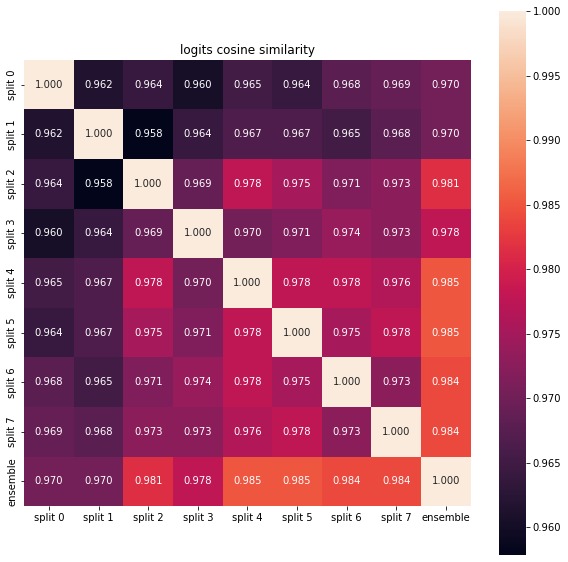

In [15]:
tmp = outputs_list.copy()
tmp = np.vstack([tmp, np.mean(outputs_list, axis=0)[None]])
tmp = 1.0 / (1.0 + np.exp(-tmp))
for index in range(len(tmp)):
    indices = np.argsort(tmp[index])[::-1][:57]
    tmp[index] *= 0.0
    tmp[index, indices] = 1.0

corrs = np.zeros((len(tmp), len(tmp)), dtype=np.float)
for index in range(len(tmp)):
    for jndex in range(index, len(tmp)):
        corrs[index, jndex] = corrs[jndex, index] = np.mean(tmp[index] == tmp[jndex])
        
plt.figure(figsize=(10, 10))
labels = ['split ' + str(index) for index in range(n_splits)] + ['ensemble']
sns.heatmap(corrs, xticklabels=labels, yticklabels=labels, square=True, annot=True, fmt='.3f')
plt.title('logits cosine similarity')
plt.show()

In [16]:
probs = 1.0 / (1.0 + np.exp(-np.mean(outputs_list, axis=0)))
test['Active'] = False
pos_labels = np.argsort(probs)[::-1][0:57]
test['Active'][pos_labels] = True
test['Active'].values[1495] = False  # <- manually fix some answers?

# test f1=0.4348
test['Active'].to_csv('submission_cv.csv')
test['Active']

0       False
1       False
2        True
3       False
4       False
        ...  
1609    False
1610    False
1611    False
1612    False
1613    False
Name: Active, Length: 1614, dtype: bool

In [44]:
test.iloc[[27, 54, 60, 167, 177, 187, 213, 220, 239, 255, 256, 260, 272, 296, 358, 366, 372, 386, 389, 402, 427, 447, 455, 487, 489, 492, 497, 521, 529, 531, 539, 542, 545, 564, 572, 590, 654, 662, 695, 698, 703, 740, 754, 779, 793, 805, 824, 832, 852, 853, 871, 888, 922, 951, 954, 961, 966, 974, 979, 990, 992, 1047, 1053, 1057, 1082, 1099, 1101, 1114, 1135, 1154, 1156, 1159, 1191, 1192, 1209, 1230, 1233, 1242, 1249, 1355, 1358, 1367, 1389, 1396, 1411, 1425, 1495, 1501, 1522, 1523, 1542, 1544, 1547, 1583, 1593, 1607]]['Active'].values.sum()

3